In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import IPython
IPython.display.Audio("ibeep.mp3",autoplay=True)

In [4]:
import numpy as np
np.set_printoptions(linewidth=np.inf)
import sympy as sp
import scipy as sc
from colorednoise import powerlaw_psd_gaussian as cn
from scipy import integrate,signal,stats,io
from sklearn.linear_model import Lasso,ridge_regression
from sklearn.utils.extmath import weighted_mode

from matplotlib import pyplot as plt
from mpl_toolkits import mplot3d
%matplotlib inline

import pysindy as ps

from tqdm import tqdm,tnrange

import copy

from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

C:\Users\rautj\Anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\rautj\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
C:\Users\rautj\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  stacklevel=1)


In [5]:
from sindy_functions import *
from systems import *

In [15]:
x0=[0,1,20]

dt=0.01
tstamps=np.arange(0,100,dt)

Sol=sc.integrate.odeint(lorenz,x0,tstamps,args=(),rtol=1e-12,atol=1e-12).T
Soldt=np.gradient(Sol.T[:,:],dt,axis=0).T

deg=2
thres=0.1
mc=SINDy(polypool(Sol[:,:].T,deg),np.gradient(Sol[:,:],dt,axis=1).T,thres,reg=1e-16,normalise='auto')
#corr=np.nan_to_num(mc/mc)
corr=np.copy(mc)

In [16]:
mc

array([[ 0.        ,  0.        ,  0.        ],
       [-9.97770114, 27.80034157,  0.        ],
       [ 9.97769637, -0.96093595,  0.        ],
       [ 0.        ,  0.        , -2.65884889],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.99706946],
       [ 0.        , -0.99441979,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ]])

In [17]:
period=0.759
Ts=np.linspace(0.1,2.5,13)[::-1]*period
srs=2**np.arange(5,18)/period
dts=1/srs

INFOs=np.zeros((len(Ts),len(dts))).tolist()

for i in tnrange(len(Ts)):
    x0=[0,1,20]

    tstamps=np.arange(0,Ts[i],dts[-1])

    Sol=sc.integrate.odeint(lorenz,x0,tstamps,args=(),rtol=1e-12,atol=1e-12).T
    for j in range(len(dts)):
        dt=dts[j]
        #print(dt/dts[-1])
        Solj=Sol[:,::int(dt/dts[-1])]
        
        INFOs[i][j]=prinfo(corr,Solj.T,Solj.T,dt,1,3,reg=1e-16,lam=0.1)

C:\Users\rautj\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  


  0%|          | 0/13 [00:00<?, ?it/s]

C:\Users\rautj\Desktop\MIR 2022\24September\mostFinalCode\jns\sindy_functions.py:82: RuntimeWarning: invalid value encountered in true_divide
  correct=np.vstack((np.nan_to_num(correct/correct),np.zeros((Xi.shape[0]-correct.shape[0],correct.shape[1]))))
C:\Users\rautj\Desktop\MIR 2022\24September\mostFinalCode\jns\sindy_functions.py:102: RuntimeWarning: invalid value encountered in true_divide
  info['STcorr']=np.all(np.nan_to_num(correct/correct)==np.nan_to_num(Xi/Xi))


C:\Users\rautj\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


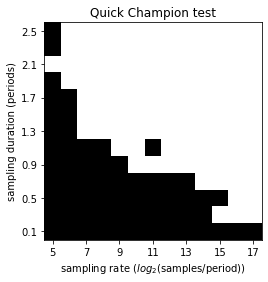

In [18]:
INFOs_STcorr=np.zeros_like(np.array(INFOs))

il,jl=np.array(INFOs).shape

for i in range(il):
    for j in range(jl):
        INFOs_STcorr[i,j]=INFOs[i][j]['STcorr']

plt.figure()
plt.title ('Quick Champion test')
plt.imshow(INFOs_STcorr.astype(np.int),'gray')
plt.xticks(np.arange(13)[::2],np.arange(5,18).astype(int)[::2])
plt.xlabel('sampling rate ($log_2$(samples/period))')
plt.yticks(np.arange(13)[::2],np.linspace(0.1,2.5,13).round(1)[::-2])
plt.ylabel('sampling duration (periods)')
plt.show()

In [19]:
period=0.759
Ts=np.linspace(0.1,3,20)[::-1]*period
srs=2**np.linspace(5,18,20)/period
dts=1/srs

INFOs_STress=[]
INFOs_STcorrs=[]
INFOs_STmerrs=[]

for k in tnrange(50):
    INFOs=np.zeros((len(Ts),len(dts))).tolist()

    for i in range(len(Ts)):
        for j in range(len(dts)):
            x0=np.random.normal([0,1,20])

            dt=dts[j]
            tstamps=np.arange(0,Ts[i],dt)

            Sol=sc.integrate.odeint(lorenz,x0,tstamps,args=(),rtol=1e-12,atol=1e-12).T

            INFOs[i][j]=prinfo(corr,Sol.T,Sol.T,dt,1,3,reg=1e-16,lam=0.1)
    
    INFOs_STres=np.zeros_like(np.array(INFOs))
    INFOs_STcorr=np.zeros_like(np.array(INFOs))
    INFOs_STmerr=np.zeros_like(np.array(INFOs))
    il,jl=np.array(INFOs).shape
    for i in range(il):
        for j in range(jl):
            INFOs_STres[i,j]=INFOs[i][j]['STres']
            INFOs_STcorr[i,j]=INFOs[i][j]['STcorr']
            INFOs_STmerr[i,j]=INFOs[i][j]['STmerr']
    
    INFOs_STress.append(INFOs_STres)
    INFOs_STcorrs.append(INFOs_STcorr.astype(np.int))
    INFOs_STmerrs.append(INFOs_STmerr)

INFOs_STressavg=np.average(INFOs_STress,axis=0)
INFOs_STcorrsavg=np.average(INFOs_STcorrs,axis=0)
INFOs_STmerrsavg=np.average(INFOs_STmerrs,axis=0)

C:\Users\rautj\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  # Remove the CWD from sys.path while we load stuff.


  0%|          | 0/50 [00:00<?, ?it/s]

C:\Users\rautj\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


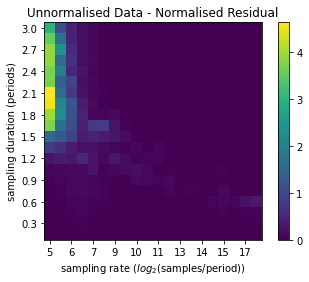

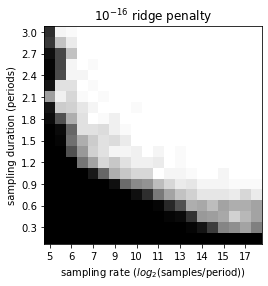

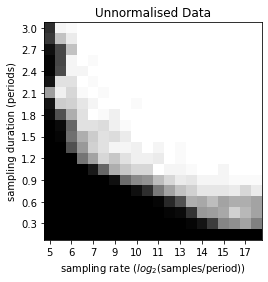

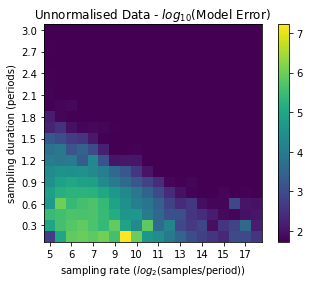

In [20]:
plt.figure()
plt.title('Unnormalised Data - Normalised Residual')
plt.imshow(np.array(INFOs_STressavg).astype(float))
plt.colorbar()
plt.xticks(np.arange(20)[::2],np.linspace(5,18,20).astype(int)[::2])
plt.xlabel('sampling rate ($log_2$(samples/period))')
plt.yticks(np.arange(20)[::2],np.linspace(0.1,3,20).round(1)[::-2])
plt.ylabel('sampling duration (periods)')
plt.show()

plt.figure()
plt.title('$10^{-16}$ ridge penalty')
plt.imshow(np.array(INFOs_STcorrsavg),'gray')
plt.xticks(np.arange(20)[::2],np.linspace(5,18,20).astype(int)[::2])
plt.xlabel('sampling rate ($log_2$(samples/period))')
plt.yticks(np.arange(20)[::2],np.linspace(0.1,3,20).round(1)[::-2])
plt.ylabel('sampling duration (periods)')
plt.show()

plt.figure()
plt.title('Unnormalised Data')
plt.imshow(np.array(INFOs_STcorrsavg),'gray')
plt.xticks(np.arange(20)[::2],np.linspace(5,18,20).astype(int)[::2])
plt.xlabel('sampling rate ($log_2$(samples/period))')
plt.yticks(np.arange(20)[::2],np.linspace(0.1,3,20).round(1)[::-2])
plt.ylabel('sampling duration (periods)')
plt.show()

plt.figure()
plt.title('Unnormalised Data - $log_{10}$(Model Error)')
plt.imshow(np.log10(np.array(INFOs_STmerrsavg).astype(float)))
plt.colorbar()
plt.xticks(np.arange(20)[::2],np.linspace(5,18,20).astype(int)[::2])
plt.xlabel('sampling rate ($log_2$(samples/period))')
plt.yticks(np.arange(20)[::2],np.linspace(0.1,3,20).round(1)[::-2])
plt.ylabel('sampling duration (periods)')
plt.show()

In [ ]:
#np.savetxt('unnf.cb',np.array(INFOs_STcorrsavg))

In [21]:
period=0.759
Ts=np.linspace(0.1,3,20)[::-1]*period
srs=2**np.linspace(5,18,20)/period
dts=1/srs

INFOs_STress=[]
INFOs_STcorrs=[]
INFOs_STmerrs=[]

for k in tnrange(50):
    INFOs=np.zeros((len(Ts),len(dts))).tolist()

    for i in range(len(Ts)):
        for j in range(len(dts)):
            x0=np.random.normal([0,1,20])

            dt=dts[j]
            tstamps=np.arange(0,Ts[i],dt)

            Sol=sc.integrate.odeint(lorenz,x0,tstamps,args=(),rtol=1e-12,atol=1e-12).T

            INFOs[i][j]=prinfo(corr,Sol.T,Sol.T,dt,1,3,reg=1e-3,lam=0.1)
    
    INFOs_STres=np.zeros_like(np.array(INFOs))
    INFOs_STcorr=np.zeros_like(np.array(INFOs))
    INFOs_STmerr=np.zeros_like(np.array(INFOs))
    il,jl=np.array(INFOs).shape
    for i in range(il):
        for j in range(jl):
            INFOs_STres[i,j]=INFOs[i][j]['STres']
            INFOs_STcorr[i,j]=INFOs[i][j]['STcorr']
            INFOs_STmerr[i,j]=INFOs[i][j]['STmerr']
    
    INFOs_STress.append(INFOs_STres)
    INFOs_STcorrs.append(INFOs_STcorr.astype(np.int))
    INFOs_STmerrs.append(INFOs_STmerr)

INFOs_STressavg=np.average(INFOs_STress,axis=0)
INFOs_STcorrsavg=np.average(INFOs_STcorrs,axis=0)
INFOs_STmerrsavg=np.average(INFOs_STmerrs,axis=0)

C:\Users\rautj\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  # Remove the CWD from sys.path while we load stuff.


  0%|          | 0/50 [00:00<?, ?it/s]

C:\Users\rautj\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


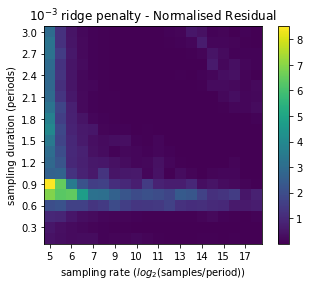

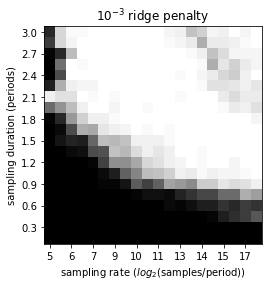

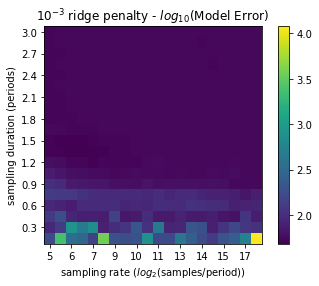

In [22]:
plt.figure()
plt.title('$10^{-3}$ ridge penalty - Normalised Residual')
plt.imshow(np.array(INFOs_STressavg).astype(float))
plt.colorbar()
plt.xticks(np.arange(20)[::2],np.linspace(5,18,20).astype(int)[::2])
plt.xlabel('sampling rate ($log_2$(samples/period))')
plt.yticks(np.arange(20)[::2],np.linspace(0.1,3,20).round(1)[::-2])
plt.ylabel('sampling duration (periods)')
plt.show()

plt.figure()
plt.title('$10^{-3}$ ridge penalty')
plt.imshow(np.array(INFOs_STcorrsavg),'gray')
plt.xticks(np.arange(20)[::2],np.linspace(5,18,20).astype(int)[::2])
plt.xlabel('sampling rate ($log_2$(samples/period))')
plt.yticks(np.arange(20)[::2],np.linspace(0.1,3,20).round(1)[::-2])
plt.ylabel('sampling duration (periods)')
plt.show()

plt.figure()
plt.title('$10^{-3}$ ridge penalty - $log_{10}$(Model Error)')
plt.imshow(np.log10(np.array(INFOs_STmerrsavg).astype(float)))
plt.colorbar()
plt.xticks(np.arange(20)[::2],np.linspace(5,18,20).astype(int)[::2])
plt.xlabel('sampling rate ($log_2$(samples/period))')
plt.yticks(np.arange(20)[::2],np.linspace(0.1,3,20).round(1)[::-2])
plt.ylabel('sampling duration (periods)')
plt.show()

In [ ]:
#np.savetxt('unnf3.cb',np.array(INFOs_STcorrsavg))

In [23]:
period=0.759
Ts=np.linspace(0.1,3,20)[::-1]*period
srs=2**np.linspace(5,18,20)/period
dts=1/srs

INFOs_STress=[]
INFOs_STcorrs=[]
INFOs_STmerrs=[]

for k in tnrange(50):
    INFOs=np.zeros((len(Ts),len(dts))).tolist()

    for i in range(len(Ts)):
        for j in range(len(dts)):
            x0=np.random.normal([0,1,20])

            dt=dts[j]
            tstamps=np.arange(0,Ts[i],dt)

            Sol=sc.integrate.odeint(lorenz,x0,tstamps,args=(),rtol=1e-12,atol=1e-12).T
            
            #x, x' normalisation - noise free

            midpoint=np.array([0,0,0])
            #midpoint=np.average(Sol,axis=1)
            #midpoint=(np.max(Sol,axis=1)+np.min(Sol,axis=1))/2
            #print('initial midpoint:',midpoint)
            Solm=Sol-np.reshape(midpoint,(-1,1))

            nc=np.abs(Solm.T).max(axis=0)
            #nc=np.array([20,26,47])
            #print('initial variable normalisation constants (division):',nc)
            nSol=Solm.T/nc
            nSol=nSol.T
            nSolnf=np.copy(nSol)

            INFOs[i][j]=prinfo(corr,nSolnf.T,nSolnf.T,dt,1,3,reg=1e-16,lam=0.1)
    
    INFOs_STres=np.zeros_like(np.array(INFOs))
    INFOs_STcorr=np.zeros_like(np.array(INFOs))
    INFOs_STmerr=np.zeros_like(np.array(INFOs))
    il,jl=np.array(INFOs).shape
    for i in range(il):
        for j in range(jl):
            INFOs_STres[i,j]=INFOs[i][j]['STres']
            INFOs_STcorr[i,j]=INFOs[i][j]['STcorr']
            INFOs_STmerr[i,j]=INFOs[i][j]['STmerr']
    
    INFOs_STress.append(INFOs_STres)
    INFOs_STcorrs.append(INFOs_STcorr.astype(np.int))
    INFOs_STmerrs.append(INFOs_STmerr)

INFOs_STressavg=np.average(INFOs_STress,axis=0)
INFOs_STcorrsavg=np.average(INFOs_STcorrs,axis=0)
INFOs_STmerrsavg=np.average(INFOs_STmerrs,axis=0)

C:\Users\rautj\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  # Remove the CWD from sys.path while we load stuff.


  0%|          | 0/50 [00:00<?, ?it/s]

C:\Users\rautj\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


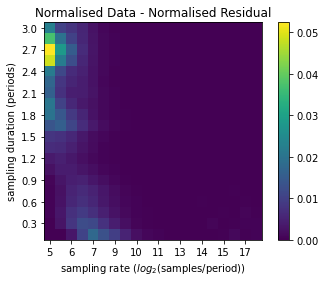

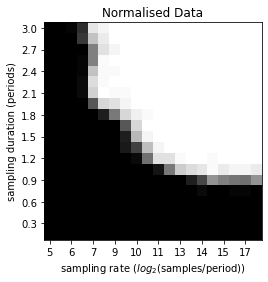

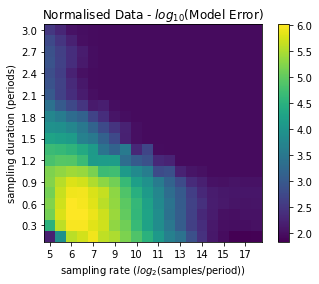

In [24]:
plt.figure()
plt.title ('Normalised Data - Normalised Residual')
plt.imshow(np.array(INFOs_STressavg).astype(float))
plt.colorbar()
plt.xticks(np.arange(20)[::2],np.linspace(5,18,20).astype(int)[::2])
plt.xlabel('sampling rate ($log_2$(samples/period))')
plt.yticks(np.arange(20)[::2],np.linspace(0.1,3,20).round(1)[::-2])
plt.ylabel('sampling duration (periods)')
plt.show()

plt.figure()
plt.title ('Normalised Data')
plt.imshow(np.array(INFOs_STcorrsavg),'gray')
plt.xticks(np.arange(20)[::2],np.linspace(5,18,20).astype(int)[::2])
plt.xlabel('sampling rate ($log_2$(samples/period))')
plt.yticks(np.arange(20)[::2],np.linspace(0.1,3,20).round(1)[::-2])
plt.ylabel('sampling duration (periods)')
plt.show()

plt.figure()
plt.title ('Normalised Data - $log_{10}$(Model Error)')
plt.imshow(np.log10(np.array(INFOs_STmerrsavg).astype(float)))
plt.colorbar()
plt.xticks(np.arange(20)[::2],np.linspace(5,18,20).astype(int)[::2])
plt.xlabel('sampling rate ($log_2$(samples/period))')
plt.yticks(np.arange(20)[::2],np.linspace(0.1,3,20).round(1)[::-2])
plt.ylabel('sampling duration (periods)')
plt.show()

In [ ]:
#np.savetxt('nnf.cb',np.array(INFOs_STcorrsavg))

In [25]:
period=0.759
Ts=np.linspace(0.1,3,20)[::-1]*period
srs=2**np.linspace(5,18,20)/period
dts=1/srs

INFOs_STress=[]
INFOs_STcorrs=[]
INFOs_STmerrs=[]

for k in tnrange(2):
    INFOs=np.zeros((len(Ts),len(dts))).tolist()

    for i in range(len(Ts)):
        for j in range(len(dts)):
            x0=np.random.normal([0,1,20])

            dt=dts[j]
            tstamps=np.arange(0,Ts[i],dt)

            Sol=sc.integrate.odeint(lorenz,x0,tstamps,args=(),rtol=1e-12,atol=1e-12).T
            
            #x, x' normalisation - noise free

            midpoint=np.array([0,0,0])
            #midpoint=np.average(Sol,axis=1)
            #midpoint=(np.max(Sol,axis=1)+np.min(Sol,axis=1))/2
            #print('initial midpoint:',midpoint)
            Solm=Sol-np.reshape(midpoint,(-1,1))

            #nc=np.abs(Solm.T).max(axis=0)
            nc=np.array([20,26,47])
            #print('initial variable normalisation constants (division):',nc)
            nSol=Solm.T/nc
            nSol=nSol.T
            nSolnf=np.copy(nSol)

            #noise addition
            #np.random.seed(1)
            nlevel=0.001
            #nSol=np.random.normal(nSol,nlevel/2)
            nSol[0]=nSol[0]+nlevel/2*cn(2,len(nSol[0]))
            nlevel=0.001
            #nSol=np.random.normal(nSol,nlevel/2)
            nSol[1]=nSol[1]+nlevel/2*cn(2,len(nSol[1]))
            nlevel=0.001
            #nSol=np.random.normal(nSol,nlevel/2)
            nSol[2]=nSol[2]+nlevel/2*cn(2,len(nSol[2]))

            #implied noisy measurements - unnormalised
            uSol=(nSol.T*nc).T+np.reshape(midpoint,(-1,1))

            #x, x' normalisation - with noise

            midpoint=np.array([0,0,0])
            #midpoint=np.average(Sol,axis=1)
            #midpoint=(np.max(uSol,axis=1)+np.min(uSol,axis=1))/2
            #print('midpoint:',midpoint)
            uSolm=uSol-np.reshape(midpoint,(-1,1))

            #nc=np.abs(uSolm.T).max(axis=0)
            nc=np.array([20,26,47])
            #print('variable normalisation constants (division):',nc)
            nSol=uSolm.T/nc
            nSol=nSol.T

            INFOs[i][j]=prinfo(corr,nSolnf.T,nSol.T,dt,1,3,reg=1e-16,lam=0.1)
    
    INFOs_STres=np.zeros_like(np.array(INFOs))
    INFOs_STcorr=np.zeros_like(np.array(INFOs))
    INFOs_STmerr=np.zeros_like(np.array(INFOs))
    il,jl=np.array(INFOs).shape
    for i in range(il):
        for j in range(jl):
            INFOs_STres[i,j]=INFOs[i][j]['STres']
            INFOs_STcorr[i,j]=INFOs[i][j]['STcorr']
            INFOs_STmerr[i,j]=INFOs[i][j]['STmerr']
    
    INFOs_STress.append(INFOs_STres)
    INFOs_STcorrs.append(INFOs_STcorr.astype(np.int))
    INFOs_STmerrs.append(INFOs_STmerr)

INFOs_STressavg=np.average(INFOs_STress,axis=0)
INFOs_STcorrsavg=np.average(INFOs_STcorrs,axis=0)
INFOs_STmerrsavg=np.average(INFOs_STmerrs,axis=0)

C:\Users\rautj\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  # Remove the CWD from sys.path while we load stuff.


  0%|          | 0/2 [00:00<?, ?it/s]

C:\Users\rautj\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


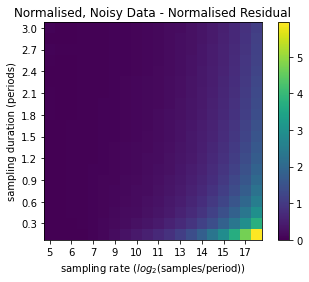

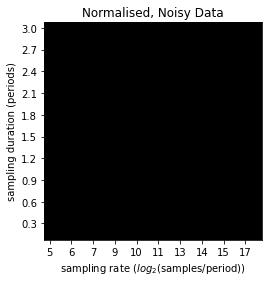

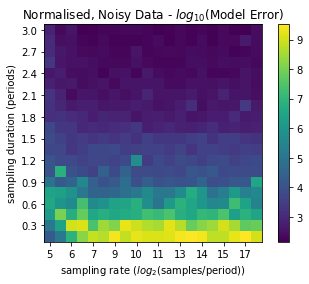

In [26]:
plt.figure()
plt.title ('Normalised, Noisy Data - Normalised Residual')
plt.imshow(np.array(INFOs_STressavg).astype(float))
plt.colorbar()
plt.xticks(np.arange(20)[::2],np.linspace(5,18,20).astype(int)[::2])
plt.xlabel('sampling rate ($log_2$(samples/period))')
plt.yticks(np.arange(20)[::2],np.linspace(0.1,3,20).round(1)[::-2])
plt.ylabel('sampling duration (periods)')
plt.show()

plt.figure()
plt.title ('Normalised, Noisy Data')
plt.imshow(np.array(INFOs_STcorrsavg),'gray')
plt.xticks(np.arange(20)[::2],np.linspace(5,18,20).astype(int)[::2])
plt.xlabel('sampling rate ($log_2$(samples/period))')
plt.yticks(np.arange(20)[::2],np.linspace(0.1,3,20).round(1)[::-2])
plt.ylabel('sampling duration (periods)')
plt.show()

plt.figure()
plt.title ('Normalised, Noisy Data - $log_{10}$(Model Error)')
plt.imshow(np.log10(np.array(INFOs_STmerrsavg).astype(float)))
plt.colorbar()
plt.xticks(np.arange(20)[::2],np.linspace(5,18,20).astype(int)[::2])
plt.xlabel('sampling rate ($log_2$(samples/period))')
plt.yticks(np.arange(20)[::2],np.linspace(0.1,3,20).round(1)[::-2])
plt.ylabel('sampling duration (periods)')
plt.show()

In [ ]:
#np.savetxt('nn.cb',np.array(INFOs_STcorrsavg))

In [27]:
period=0.759
Ts=np.linspace(0.1,3,20)[::-1]*period
srs=2**np.linspace(5,18,20)/period
dts=1/srs

INFOs_STress=[]
INFOs_STcorrs=[]
INFOs_STmerrs=[]

for k in tnrange(50):
    INFOs=np.zeros((len(Ts),len(dts))).tolist()

    for i in range(len(Ts)):
        for j in range(len(dts)):
            x0=np.random.normal([0,1,20])

            dt=dts[j]
            tstamps=np.arange(0,Ts[i],dt)

            Sol=sc.integrate.odeint(lorenz,x0,tstamps,args=(),rtol=1e-12,atol=1e-12).T
            
            #x, x' normalisation - noise free

            midpoint=np.array([0,0,0])
            #midpoint=np.average(Sol,axis=1)
            #midpoint=(np.max(Sol,axis=1)+np.min(Sol,axis=1))/2
            #print('initial midpoint:',midpoint)
            Solm=Sol-np.reshape(midpoint,(-1,1))

            #nc=np.abs(Solm.T).max(axis=0)
            nc=np.array([20,26,47])
            #print('initial variable normalisation constants (division):',nc)
            nSol=Solm.T/nc
            nSol=nSol.T
            nSolnf=np.copy(nSol)

            #noise addition
            #np.random.seed(1)
            nlevel=0.001
            #nSol=np.random.normal(nSol,nlevel/2)
            nSol[0]=nSol[0]+nlevel/2*cn(0,len(nSol[0]))
            nlevel=0.001
            #nSol=np.random.normal(nSol,nlevel/2)
            nSol[1]=nSol[1]+nlevel/2*cn(0,len(nSol[1]))
            nlevel=0.001
            #nSol=np.random.normal(nSol,nlevel/2)
            nSol[2]=nSol[2]+nlevel/2*cn(0,len(nSol[2]))

            #implied noisy measurements - unnormalised
            uSol=(nSol.T*nc).T+np.reshape(midpoint,(-1,1))

            #x, x' normalisation - with noise

            midpoint=np.array([0,0,0])
            #midpoint=np.average(Sol,axis=1)
            #midpoint=(np.max(uSol,axis=1)+np.min(uSol,axis=1))/2
            #print('midpoint:',midpoint)
            uSolm=uSol-np.reshape(midpoint,(-1,1))

            #nc=np.abs(uSolm.T).max(axis=0)
            nc=np.array([20,26,47])
            #print('variable normalisation constants (division):',nc)
            nSol=uSolm.T/nc
            nSol=nSol.T

            INFOs[i][j]=prinfo(corr,Sol.T,uSol.T,dt,1,3,reg=1e-16,lam=0.1)
    
    INFOs_STres=np.zeros_like(np.array(INFOs))
    INFOs_STcorr=np.zeros_like(np.array(INFOs))
    INFOs_STmerr=np.zeros_like(np.array(INFOs))
    il,jl=np.array(INFOs).shape
    for i in range(il):
        for j in range(jl):
            INFOs_STres[i,j]=INFOs[i][j]['STres']
            INFOs_STcorr[i,j]=INFOs[i][j]['STcorr']
            INFOs_STmerr[i,j]=INFOs[i][j]['STmerr']
    
    INFOs_STress.append(INFOs_STres)
    INFOs_STcorrs.append(INFOs_STcorr.astype(np.int))
    INFOs_STmerrs.append(INFOs_STmerr)

INFOs_STressavg=np.average(INFOs_STress,axis=0)
INFOs_STcorrsavg=np.average(INFOs_STcorrs,axis=0)
INFOs_STmerrsavg=np.average(INFOs_STmerrs,axis=0)

C:\Users\rautj\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  # Remove the CWD from sys.path while we load stuff.


  0%|          | 0/50 [00:00<?, ?it/s]

C:\Users\rautj\Anaconda3\lib\site-packages\ipykernel_launcher.py:79: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


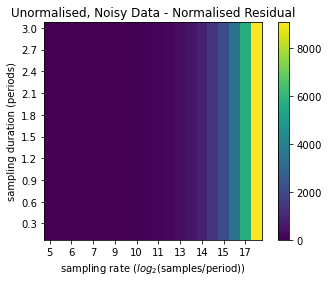

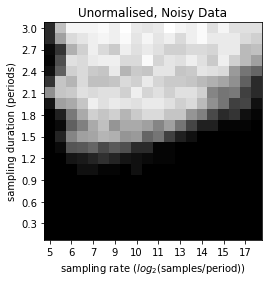

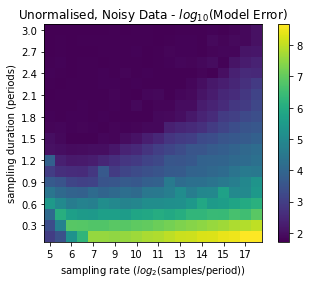

In [28]:
plt.figure()
plt.title ('Unormalised, Noisy Data - Normalised Residual')
plt.imshow(np.array(INFOs_STressavg).astype(float))
plt.colorbar()
plt.xticks(np.arange(20)[::2],np.linspace(5,18,20).astype(int)[::2])
plt.xlabel('sampling rate ($log_2$(samples/period))')
plt.yticks(np.arange(20)[::2],np.linspace(0.1,3,20).round(1)[::-2])
plt.ylabel('sampling duration (periods)')
plt.show()

plt.figure()
plt.title ('Unormalised, Noisy Data')
plt.imshow(np.array(INFOs_STcorrsavg),'gray')
plt.xticks(np.arange(20)[::2],np.linspace(5,18,20).astype(int)[::2])
plt.xlabel('sampling rate ($log_2$(samples/period))')
plt.yticks(np.arange(20)[::2],np.linspace(0.1,3,20).round(1)[::-2])
plt.ylabel('sampling duration (periods)')
plt.show()

plt.figure()
plt.title ('Unormalised, Noisy Data - $log_{10}$(Model Error)')
plt.imshow(np.log10(np.array(INFOs_STmerrsavg).astype(float)))
plt.colorbar()
plt.xticks(np.arange(20)[::2],np.linspace(5,18,20).astype(int)[::2])
plt.xlabel('sampling rate ($log_2$(samples/period))')
plt.yticks(np.arange(20)[::2],np.linspace(0.1,3,20).round(1)[::-2])
plt.ylabel('sampling duration (periods)')
plt.show()

In [ ]:
#np.savetxt('unn0.cb',np.array(INFOs_STcorrsavg))

In [ ]:
period=0.759
Ts=np.linspace(0.1,3,20)[::-1]*period
srs=2**np.linspace(5,18,20)/period
dts=1/srs

INFOs_STress=[]
INFOs_STcorrs=[]
INFOs_STmerrs=[]

for k in tnrange(50):
    INFOs=np.zeros((len(Ts),len(dts))).tolist()

    for i in range(len(Ts)):
        for j in range(len(dts)):
            x0=np.random.normal([0,1,20])

            dt=dts[j]
            tstamps=np.arange(0,Ts[i],dt)

            Sol=sc.integrate.odeint(lorenz,x0,tstamps,args=(),rtol=1e-12,atol=1e-12).T
            
            #x, x' normalisation - noise free

            midpoint=np.array([0,0,0])
            #midpoint=np.average(Sol,axis=1)
            #midpoint=(np.max(Sol,axis=1)+np.min(Sol,axis=1))/2
            #print('initial midpoint:',midpoint)
            Solm=Sol-np.reshape(midpoint,(-1,1))

            #nc=np.abs(Solm.T).max(axis=0)
            nc=np.array([20,26,47])
            #print('initial variable normalisation constants (division):',nc)
            nSol=Solm.T/nc
            nSol=nSol.T
            nSolnf=np.copy(nSol)

            #noise addition
            #np.random.seed(1)
            nlevel=0.001
            #nSol=np.random.normal(nSol,nlevel/2)
            nSol[0]=nSol[0]+nlevel/2*cn(1,len(nSol[0]))
            nlevel=0.001
            #nSol=np.random.normal(nSol,nlevel/2)
            nSol[1]=nSol[1]+nlevel/2*cn(1,len(nSol[1]))
            nlevel=0.001
            #nSol=np.random.normal(nSol,nlevel/2)
            nSol[2]=nSol[2]+nlevel/2*cn(1,len(nSol[2]))

            #implied noisy measurements - unnormalised
            uSol=(nSol.T*nc).T+np.reshape(midpoint,(-1,1))

            #x, x' normalisation - with noise

            midpoint=np.array([0,0,0])
            #midpoint=np.average(Sol,axis=1)
            #midpoint=(np.max(uSol,axis=1)+np.min(uSol,axis=1))/2
            #print('midpoint:',midpoint)
            uSolm=uSol-np.reshape(midpoint,(-1,1))

            #nc=np.abs(uSolm.T).max(axis=0)
            nc=np.array([20,26,47])
            #print('variable normalisation constants (division):',nc)
            nSol=uSolm.T/nc
            nSol=nSol.T

            INFOs[i][j]=prinfo(corr,Sol.T,uSol.T,dt,1,3,reg=1e-16,lam=0.1)
    
    INFOs_STres=np.zeros_like(np.array(INFOs))
    INFOs_STcorr=np.zeros_like(np.array(INFOs))
    INFOs_STmerr=np.zeros_like(np.array(INFOs))
    il,jl=np.array(INFOs).shape
    for i in range(il):
        for j in range(jl):
            INFOs_STres[i,j]=INFOs[i][j]['STres']
            INFOs_STcorr[i,j]=INFOs[i][j]['STcorr']
            INFOs_STmerr[i,j]=INFOs[i][j]['STmerr']
    
    INFOs_STress.append(INFOs_STres)
    INFOs_STcorrs.append(INFOs_STcorr.astype(np.int))
    INFOs_STmerrs.append(INFOs_STmerr)

INFOs_STressavg=np.average(INFOs_STress,axis=0)
INFOs_STcorrsavg=np.average(INFOs_STcorrs,axis=0)
INFOs_STmerrsavg=np.average(INFOs_STmerrs,axis=0)

In [ ]:
plt.figure()
plt.title ('Unormalised, Noisy Data - Normalised Residual')
plt.imshow(np.array(INFOs_STressavg).astype(float))
plt.colorbar()
plt.xticks(np.arange(20)[::2],np.linspace(5,18,20).astype(int)[::2])
plt.xlabel('sampling rate ($log_2$(samples/period))')
plt.yticks(np.arange(20)[::2],np.linspace(0.1,3,20).round(1)[::-2])
plt.ylabel('sampling duration (periods)')
plt.show()

plt.figure()
plt.title ('Unormalised, Noisy Data')
plt.imshow(np.array(INFOs_STcorrsavg),'gray')
plt.xticks(np.arange(20)[::2],np.linspace(5,18,20).astype(int)[::2])
plt.xlabel('sampling rate ($log_2$(samples/period))')
plt.yticks(np.arange(20)[::2],np.linspace(0.1,3,20).round(1)[::-2])
plt.ylabel('sampling duration (periods)')
plt.show()

plt.figure()
plt.title ('Unormalised, Noisy Data - $log_{10}$(Model Error)')
plt.imshow(np.log10(np.array(INFOs_STmerrsavg).astype(float)))
plt.colorbar()
plt.xticks(np.arange(20)[::2],np.linspace(5,18,20).astype(int)[::2])
plt.xlabel('sampling rate ($log_2$(samples/period))')
plt.yticks(np.arange(20)[::2],np.linspace(0.1,3,20).round(1)[::-2])
plt.ylabel('sampling duration (periods)')
plt.show()

In [ ]:
#np.savetxt('unn1.cb',np.array(INFOs_STcorrsavg))

In [ ]:
period=0.759
Ts=np.linspace(0.1,3,20)[::-1]*period
srs=2**np.linspace(5,18,20)/period
dts=1/srs

INFOs_STress=[]
INFOs_STcorrs=[]
INFOs_STmerrs=[]

for k in tnrange(50):
    INFOs=np.zeros((len(Ts),len(dts))).tolist()

    for i in range(len(Ts)):
        for j in range(len(dts)):
            x0=np.random.normal([0,1,20])

            dt=dts[j]
            tstamps=np.arange(0,Ts[i],dt)

            Sol=sc.integrate.odeint(lorenz,x0,tstamps,args=(),rtol=1e-12,atol=1e-12).T
            
            #x, x' normalisation - noise free

            midpoint=np.array([0,0,0])
            #midpoint=np.average(Sol,axis=1)
            #midpoint=(np.max(Sol,axis=1)+np.min(Sol,axis=1))/2
            #print('initial midpoint:',midpoint)
            Solm=Sol-np.reshape(midpoint,(-1,1))

            #nc=np.abs(Solm.T).max(axis=0)
            nc=np.array([20,26,47])
            #print('initial variable normalisation constants (division):',nc)
            nSol=Solm.T/nc
            nSol=nSol.T
            nSolnf=np.copy(nSol)

            #noise addition
            #np.random.seed(1)
            nlevel=0.001
            #nSol=np.random.normal(nSol,nlevel/2)
            nSol[0]=nSol[0]+nlevel/2*cn(2,len(nSol[0]))
            nlevel=0.001
            #nSol=np.random.normal(nSol,nlevel/2)
            nSol[1]=nSol[1]+nlevel/2*cn(2,len(nSol[1]))
            nlevel=0.001
            #nSol=np.random.normal(nSol,nlevel/2)
            nSol[2]=nSol[2]+nlevel/2*cn(2,len(nSol[2]))

            #implied noisy measurements - unnormalised
            uSol=(nSol.T*nc).T+np.reshape(midpoint,(-1,1))

            #x, x' normalisation - with noise

            midpoint=np.array([0,0,0])
            #midpoint=np.average(Sol,axis=1)
            #midpoint=(np.max(uSol,axis=1)+np.min(uSol,axis=1))/2
            #print('midpoint:',midpoint)
            uSolm=uSol-np.reshape(midpoint,(-1,1))

            #nc=np.abs(uSolm.T).max(axis=0)
            nc=np.array([20,26,47])
            #print('variable normalisation constants (division):',nc)
            nSol=uSolm.T/nc
            nSol=nSol.T

            INFOs[i][j]=prinfo(corr,Sol.T,uSol.T,dt,1,3,reg=1e-16,lam=0.1)
    
    INFOs_STres=np.zeros_like(np.array(INFOs))
    INFOs_STcorr=np.zeros_like(np.array(INFOs))
    INFOs_STmerr=np.zeros_like(np.array(INFOs))
    il,jl=np.array(INFOs).shape
    for i in range(il):
        for j in range(jl):
            INFOs_STres[i,j]=INFOs[i][j]['STres']
            INFOs_STcorr[i,j]=INFOs[i][j]['STcorr']
            INFOs_STmerr[i,j]=INFOs[i][j]['STmerr']
    
    INFOs_STress.append(INFOs_STres)
    INFOs_STcorrs.append(INFOs_STcorr.astype(np.int))
    INFOs_STmerrs.append(INFOs_STmerr)

INFOs_STressavg=np.average(INFOs_STress,axis=0)
INFOs_STcorrsavg=np.average(INFOs_STcorrs,axis=0)
INFOs_STmerrsavg=np.average(INFOs_STmerrs,axis=0)

In [ ]:
plt.figure()
plt.title ('Unormalised, Noisy Data - Normalised Residual')
plt.imshow(np.array(INFOs_STressavg).astype(float))
plt.colorbar()
plt.xticks(np.arange(20)[::2],np.linspace(5,18,20).astype(int)[::2])
plt.xlabel('sampling rate ($log_2$(samples/period))')
plt.yticks(np.arange(20)[::2],np.linspace(0.1,3,20).round(1)[::-2])
plt.ylabel('sampling duration (periods)')
plt.show()

plt.figure()
plt.title ('Unormalised, Noisy Data')
plt.imshow(np.array(INFOs_STcorrsavg),'gray')
plt.xticks(np.arange(20)[::2],np.linspace(5,18,20).astype(int)[::2])
plt.xlabel('sampling rate ($log_2$(samples/period))')
plt.yticks(np.arange(20)[::2],np.linspace(0.1,3,20).round(1)[::-2])
plt.ylabel('sampling duration (periods)')
plt.show()

plt.figure()
plt.title ('Unormalised, Noisy Data - $log_{10}$(Model Error)')
plt.imshow(np.log10(np.array(INFOs_STmerrsavg).astype(float)))
plt.colorbar()
plt.xticks(np.arange(20)[::2],np.linspace(5,18,20).astype(int)[::2])
plt.xlabel('sampling rate ($log_2$(samples/period))')
plt.yticks(np.arange(20)[::2],np.linspace(0.1,3,20).round(1)[::-2])
plt.ylabel('sampling duration (periods)')
plt.show()

In [ ]:
#np.savetxt('unn2.cb',np.array(INFOs_STcorrsavg))

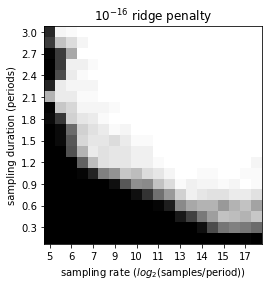

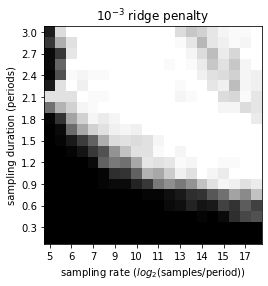

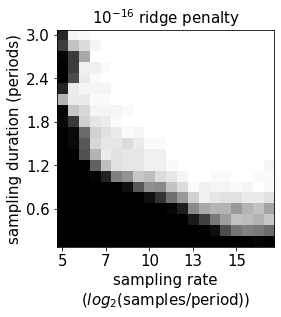

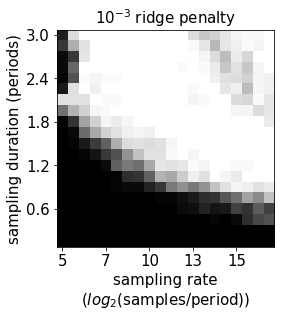

In [29]:
plt.figure()
plt.title ('$10^{-16}$ ridge penalty')
plt.imshow(np.array(np.loadtxt('unnf.cb')),'gray')
plt.xticks(np.arange(20)[::2],np.linspace(5,18,20).astype(int)[::2])
plt.xlabel('sampling rate ($log_2$(samples/period))')
plt.yticks(np.arange(20)[::2],np.linspace(0.1,3,20).round(1)[::-2])
plt.ylabel('sampling duration (periods)')
plt.show()

plt.figure()
plt.title ('$10^{-3}$ ridge penalty')
plt.imshow(np.array(np.loadtxt('unnf3.cb')),'gray')
plt.xticks(np.arange(20)[::2],np.linspace(5,18,20).astype(int)[::2])
plt.xlabel('sampling rate ($log_2$(samples/period))')
plt.yticks(np.arange(20)[::2],np.linspace(0.1,3,20).round(1)[::-2])
plt.ylabel('sampling duration (periods)')
plt.show()

plt.figure()
plt.title ('$10^{-16}$ ridge penalty',fontsize=15)
plt.imshow(np.array(np.loadtxt('unnf.cb')),'gray')
plt.xticks(np.arange(20)[::4],np.linspace(5,18,20).astype(int)[::4],fontsize=15)
plt.xlabel('sampling rate\n($log_2$(samples/period))',fontsize=15)
plt.yticks(np.arange(20)[::4],np.linspace(0.1,3,20).round(1)[::-4],fontsize=15)
plt.ylabel('sampling duration (periods)',fontsize=15)
plt.show()

plt.figure()
plt.title ('$10^{-3}$ ridge penalty',fontsize=15)
plt.imshow(np.array(np.loadtxt('unnf3.cb')),'gray')
plt.xticks(np.arange(20)[::4],np.linspace(5,18,20).astype(int)[::4],fontsize=15)
plt.xlabel('sampling rate\n($log_2$(samples/period))',fontsize=15)
plt.yticks(np.arange(20)[::4],np.linspace(0.1,3,20).round(1)[::-4],fontsize=15)
plt.ylabel('sampling duration (periods)',fontsize=15)
plt.show()

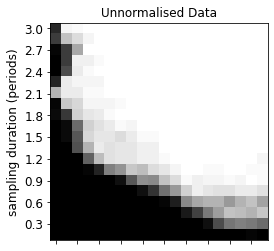

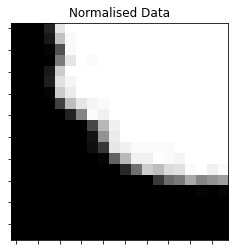

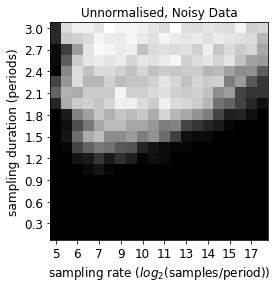

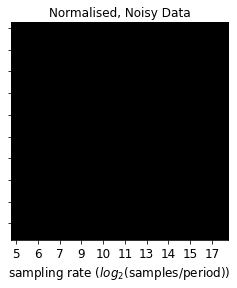

In [30]:
plt.figure()
plt.title ('Unnormalised Data',fontsize=12)
plt.imshow(np.array(np.loadtxt('unnf.cb')),'gray')
#plt.xticks(np.arange(20)[::2],np.linspace(5,18,20).astype(int)[::2],fontsize=12)
plt.xticks(np.arange(20)[::2],['']*len(np.arange(20)[::2]))
#plt.xlabel('sampling rate ($log_2$(samples/period))',fontsize=12)
plt.yticks(np.arange(20)[::2],np.linspace(0.1,3,20).round(1)[::-2],fontsize=12)
plt.ylabel('sampling duration (periods)',fontsize=12)
plt.show()

plt.figure()
plt.title ('Normalised Data',fontsize=12)
plt.imshow(np.array(np.loadtxt('nnf.cb')),'gray')
#plt.xticks(np.arange(20)[::2],np.linspace(5,18,20).astype(int)[::2],fontsize=12)
plt.xticks(np.arange(20)[::2],['']*len(np.arange(20)[::2]))
#plt.xlabel('sampling rate ($log_2$(samples/period))',fontsize=12)
#plt.yticks(np.arange(20)[::2],np.linspace(0.1,3,20).round(1)[::-2],fontsize=12)
plt.yticks(np.arange(20)[::2],['']*len(np.arange(20)[::2]))
#plt.ylabel('sampling duration (periods)',fontsize=12)
plt.show()

plt.figure()
plt.title ('Unnormalised, Noisy Data',fontsize=12)
plt.imshow(np.array(np.loadtxt('unn0.cb')),'gray')
plt.xticks(np.arange(20)[::2],np.linspace(5,18,20).astype(int)[::2],fontsize=12)
plt.xlabel('sampling rate ($log_2$(samples/period))',fontsize=12)
plt.yticks(np.arange(20)[::2],np.linspace(0.1,3,20).round(1)[::-2],fontsize=12)
plt.ylabel('sampling duration (periods)',fontsize=12)
plt.show()

plt.figure()
plt.title ('Normalised, Noisy Data',fontsize=12)
plt.imshow(np.array(np.loadtxt('nn.cb')),'gray')
plt.xticks(np.arange(20)[::2],np.linspace(5,18,20).astype(int)[::2],fontsize=12)
plt.xlabel('sampling rate ($log_2$(samples/period))',fontsize=12)
#plt.yticks(np.arange(20)[::2],np.linspace(0.1,3,20).round(1)[::-2],fontsize=12)
plt.yticks(np.arange(20)[::2],['']*len(np.arange(20)[::2]))
#plt.ylabel('sampling duration (periods)',fontsize=12)
plt.show()

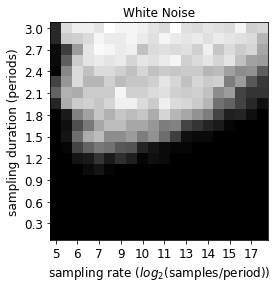

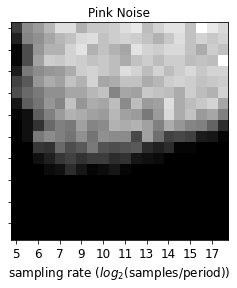

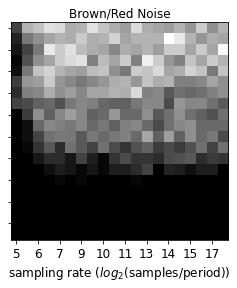

In [6]:
plt.figure()
plt.title ('White Noise',fontsize=12)
plt.imshow(np.array(np.loadtxt('unn0.cb')),'gray')
plt.xticks(np.arange(20)[::2],np.linspace(5,18,20).astype(int)[::2],fontsize=12)
plt.xlabel('sampling rate ($log_2$(samples/period))',fontsize=12)
plt.yticks(np.arange(20)[::2],np.linspace(0.1,3,20).round(1)[::-2],fontsize=12)
plt.ylabel('sampling duration (periods)',fontsize=12)
plt.show()

plt.figure()
plt.title ('Pink Noise',fontsize=12)
plt.imshow(np.array(np.loadtxt('unn1.cb')),'gray')
plt.xticks(np.arange(20)[::2],np.linspace(5,18,20).astype(int)[::2],fontsize=12)
plt.xlabel('sampling rate ($log_2$(samples/period))',fontsize=12)
#plt.yticks(np.arange(20)[::2],np.linspace(0.1,3,20).round(1)[::-2],fontsize=12)
plt.yticks(np.arange(20)[::2],['']*len(np.arange(20)[::2]))
#plt.ylabel('sampling duration (periods)',fontsize=12)
plt.show()

plt.figure()
plt.title ('Brown/Red Noise',fontsize=12)
plt.imshow(np.array(np.loadtxt('unn2.cb')),'gray')
plt.xticks(np.arange(20)[::2],np.linspace(5,18,20).astype(int)[::2],fontsize=12)
plt.xlabel('sampling rate ($log_2$(samples/period))',fontsize=12)
#plt.yticks(np.arange(20)[::2],np.linspace(0.1,3,20).round(1)[::-2],fontsize=12)
plt.yticks(np.arange(20)[::2],['']*len(np.arange(20)[::2]))
#plt.ylabel('sampling duration (periods)',fontsize=12)
plt.show()